# Exploratatory Analysis of the GECKO-A data set

Before we can apply any machine learning techniques, we need to explore the data available. Data is almost always presented in a way that makes building a model difficult if not impossible. This can be due to missing data, incorrect data types, variability in values between features that make modeling difficult, or any other number of reasons. We're going to start with loading the dataset. Then we will do some initial analysis of the data. How is it typed? What is the [Tukey 5-number Summary](https://machinelearningmastery.com/how-to-calculate-the-5-number-summary-for-your-data-in-python/#:~:text=The%20five%2Dnumber%20summary%2C%20or,for%20data%20with%20any%20distribution.)? How is the data distributed? Are the data in the features correlated? Then we move on to how we can scale and normalize the data to better help our algorithms solve for a model that can hopefully generalize well.

## Loading the data

We are going to be using the GECKO-A data. 

**Note that in the future I am going to want to implement a way to publicly retrieve this data. Also it may be stored in the parquet format rather than csv**

In [167]:
# We're going to use the very popular pandas library to import our data
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
import sklearn
%matplotlib inline

In [2]:
file_path = "/glade/p/cisl/aiml/gecko/ML2019_toluene_postproc_NEW/ML2019_toluene_ML2019_Exp1000.csv"

We can load the data and take a peek using the pd.head() function. 

In [3]:
dataFrame = pd.read_csv(file_path)
dataFrame.head()

,Time [s],Precursor [ug/m3],Temperature [K],OH [molec/cm3],O3 [molec/cm3],NOx [molec/cm3],SZA [degree],Gas [ug/m3] Bin01: lg(C*) = -6.5,Gas [ug/m3] Bin02: lg(C*) = -5.5,Gas [ug/m3] Bin03: lg(C*) = -4.5,...,N/C Bin05: lg(C*) = -2.5,N/C Bin06: lg(C*) = -1.5,N/C Bin07: lg(C*) = -0.5,N/C Bin08: lg(C*) = 0.5,N/C Bin09: lg(C*) = 1.5,N/C Bin10: lg(C*) = 2.5,N/C Bin11: lg(C*) = 3.5,N/C Bin12: lg(C*) = 4.5,N/C Bin13: lg(C*) = 5.5,N/C Bin14: lg(C*) = 6.5
0,1.000000,0.037689,298.179718,2634522.0,2.865347e+12,1.738747e+10,156.839686,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,301.207794,0.037522,298.179718,2634522.0,2.865347e+12,2.857613e+11,156.845342,1.437334e-17,1.239800e-12,5.477925e-13,...,0.276480,0.196323,0.146863,0.211432,0.079300,0.143338,0.010915,0.137913,0.080868,0.000905
2,601.415588,0.037355,298.092407,2634522.0,2.865347e+12,5.082960e+11,156.787255,1.273297e-17,1.094499e-12,4.821359e-13,...,0.278963,0.139626,0.038531,0.229156,0.093255,0.146419,0.032462,0.137106,0.051741,0.001997
3,901.623352,0.037189,298.005127,2634522.0,2.865347e+12,6.930831e+11,156.665902,1.144432e-17,9.674742e-13,4.288795e-13,...,0.281173,0.080940,0.038050,0.244181,0.098729,0.151842,0.056919,0.136595,0.040094,0.003167
4,1201.831177,0.037024,297.917938,2634522.0,2.865347e+12,8.467239e+11,156.482265,1.085807e-17,8.611497e-13,3.972799e-13,...,0.282642,0.058053,0.046640,0.258280,0.101695,0.159428,0.079230,0.136029,0.035332,0.004402


Already we can see what features are included in the data and get an idea of variablity in scale. Let's do some further formal investigation.

In [4]:
dataFrame.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 133 columns):
 #    Column                                                                                                                           Dtype  
---   ------                                                                                                                           -----  
 0     Time [s]                                                                                                                        float64
 1     Precursor [ug/m3]                                                                                                               float64
 2     Temperature [K]                                                                                                                 float64
 3     OH [molec/cm3]                                                                                                                  float64
 4     O3 [molec/cm3]             

In [5]:
mean_list = [dataFrame[x].mean() for x in dataFrame]
variane_list = [dataFrame[x].var(ddof=1) for x in dataFrame]

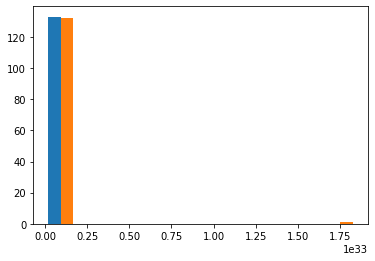

In [6]:
_ = plt.hist([mean_list,variane_list]);
plt.show()

We can already see that there are 133 features in this matrix of data, there are 1440 time steps and the data is not well distributed at all.

There are a few ways we can distribute the data a little better. It's much easier to work with something that follows somewhat of a gaussian distribution. like the following:

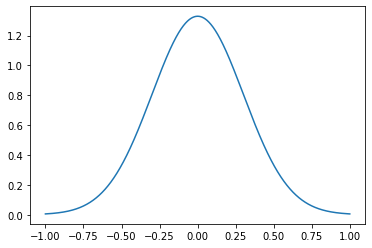

In [23]:
# Plot between -1 and 1 with .001 steps.
x_axis = np.arange(-1, 1, 0.001)
# Mean = 0, SD = 2.
plt.plot(x_axis, stats.norm.pdf(x_axis,0,0.3))
plt.show()

In [156]:
sample = np.random.choice(dataFrame.columns, size = 10)
print(sample)

[' Gas [ug/m3] Bin06: lg(C*) = -1.5' ' O/C Bin13: lg(C*) =  5.5'
 ' MW [g/mol] Bin13: lg(C*) =  5.5' ' Kh [M/atm] Bin03: lg(C*) = -4.5'
 ' N/C Bin03: lg(C*) = -4.5' ' Gas [ug/m3] Bin05: lg(C*) = -2.5'
 ' Aerosol [ug_m3] Bin13: lg(C*) =  5.5'
 ' Kh [M/atm] Bin05: lg(C*) = -2.5' ' dH [J/mol] Bin14: lg(C*) =  6.5'
 ' Gas [ug/m3] Bin04: lg(C*) = -3.5']


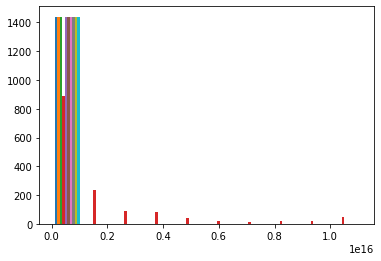

In [157]:
sampled_data = dataFrame.loc[:,sample]
_ = plt.hist(sampled_data)

In [158]:
scaler = StandardScaler()
scaler  = scaler.fit(sampled_data)
sampled_data_scaled = scaler.transform(sampled_data)

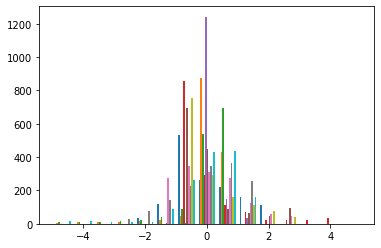

In [161]:
_ = plt.hist(sampled_data_scaled, bins = 15, range = [-5,5])

In [177]:
dataFrameArray = dataFrame.loc[::].values

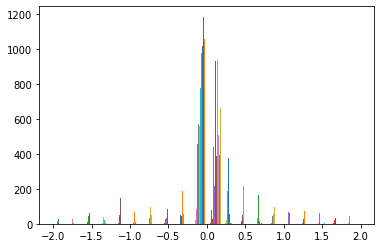

In [189]:
pca = sklearn.decomposition.PCA(n_components=130)
pca.fit(dataFrameArray)
X = pca.transform(dataFrameArray)
_ = plt.hist(X, range = [-2,2], bins = 20)